In [33]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TRUE_DIR = "mixed_precision_true"
FALSE_DIR = "mixed_precision_false"

RESULTS_TRUE_DIR = "results/mixed_precision_true"
RESULTS_FALSE_DIR = "results/mixed_precision_false"

POWER_COL = "SYSTEM_POWER (Watts)"
TIME_COL = "Time"
DELTA_COL = "Delta"


def load_energy(folder, mode_label):
    files = glob.glob(os.path.join(folder, "run_*.csv"))
    dfs = []

    for f in files:
        df = pd.read_csv(f)
        df["mode"] = mode_label
        df["run_file"] = os.path.basename(f)
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)


def load_results(folder, mode_label):
    files = glob.glob(os.path.join(folder, "run_*.csv"))
    dfs = []

    for f in files:
        df = pd.read_csv(f)
        df["mode"] = mode_label
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)


energy_true = load_energy(TRUE_DIR, "mixed")
energy_false = load_energy(FALSE_DIR, "fp32")
energy_df = pd.concat([energy_true, energy_false], ignore_index=True)

results_true = load_results(RESULTS_TRUE_DIR, "mixed")
results_false = load_results(RESULTS_FALSE_DIR, "fp32")
results_df = pd.concat([results_true, results_false], ignore_index=True)

print("Energy rows:", len(energy_df))
print("Results rows:", len(results_df))


Energy rows: 70221
Results rows: 60


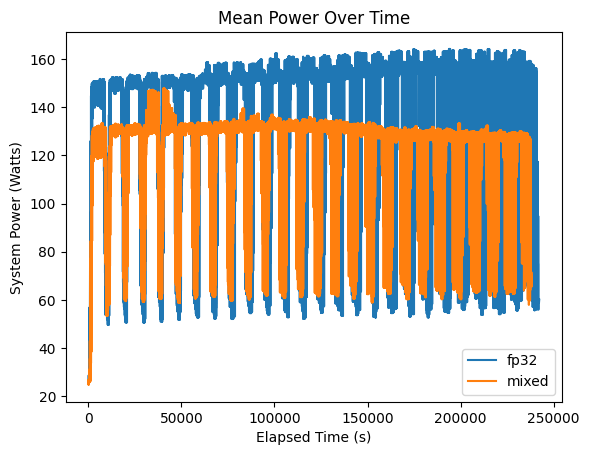

In [34]:
# Normalize time per run (start at 0)
energy_df["elapsed_time"] = energy_df.groupby("run_file")[TIME_COL].transform(lambda x: x - x.min())

mean_power = (
    energy_df
    .groupby(["mode", "elapsed_time"])[POWER_COL]
    .mean()
    .reset_index()
)

plt.figure()

for mode in mean_power["mode"].unique():
    subset = mean_power[mean_power["mode"] == mode]
    plt.plot(subset["elapsed_time"], subset[POWER_COL], label=mode)

plt.xlabel("Elapsed Time (s)")
plt.ylabel("System Power (Watts)")
plt.title("Mean Power Over Time")
plt.legend()
plt.show()


In [35]:
def compute_total_energy(df):
    totals = []

    for run_file, group in df.groupby("run_file"):
        mode = group["mode"].iloc[0]

        energy = np.sum(group[POWER_COL] * group[DELTA_COL])

        totals.append({
            "run_file": run_file,
            "mode": mode,
            "total_energy_joules": energy
        })

    return pd.DataFrame(totals)


energy_totals = compute_total_energy(energy_df)
energy_totals.head()


,run_file,mode,total_energy_joules
0,run_0.csv,fp32,3.169666e+07
1,run_1.csv,mixed,2.810900e+07
2,run_10.csv,mixed,2.790522e+07
3,run_11.csv,fp32,3.191291e+07
4,run_12.csv,fp32,3.178758e+07


In [36]:
from scipy.stats import zscore

# Compute total energy and total time per run
totals = []
for run_file, group in energy_df.groupby("run_file"):
    mode = group["mode"].iloc[0]
    run_id = int(run_file.split("run_")[1].split(".csv")[0])

    total_energy = np.sum(group[POWER_COL] * group[DELTA_COL])
    total_time = np.sum(group[DELTA_COL])

    totals.append({
        "run_file": run_file,
        "mode": mode,
        "run_id": run_id,
        "total_energy_joules": total_energy,
        "total_time_seconds": total_time
    })

energy_totals = pd.DataFrame(totals)

filtered_energy_totals = []
for mode in ["fp32", "mixed"]:
    subset = energy_totals[energy_totals["mode"] == mode].copy()
    z_scores = zscore(subset["total_energy_joules"])

    outliers = subset[np.abs(z_scores) > 3]
    if len(outliers) > 0:
        print(f"Outliers detected in {mode}:")
        print(outliers[[
            "run_file",
            "run_id",
            "total_energy_joules",
            "total_time_seconds"
        ]])
        print()
    subset = subset[np.abs(z_scores) <= 3]
    filtered_energy_totals.append(subset)

filtered_energy_totals = pd.concat(filtered_energy_totals, ignore_index=True)

print("Original runs:", len(energy_totals))
print("Filtered runs:", len(filtered_energy_totals))

Outliers detected in fp32:
     run_file  run_id  total_energy_joules  total_time_seconds
12  run_2.csv       2         3.255714e+07              234500

Original runs: 60
Filtered runs: 59


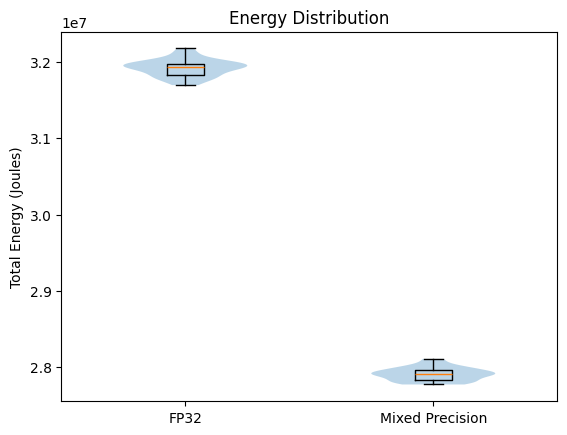

In [37]:
plt.figure()

fp32_data = filtered_energy_totals[filtered_energy_totals["mode"] == "fp32"]["total_energy_joules"]
mixed_data = filtered_energy_totals[filtered_energy_totals["mode"] == "mixed"]["total_energy_joules"]
data = [fp32_data, mixed_data]

parts = plt.violinplot(
    data,
    positions=[1, 2],
    showmeans=False,
    showmedians=False,
    showextrema=False
)

plt.boxplot(
    data,
    positions=[1, 2],
    widths=0.15
)

plt.xticks([1, 2], ["FP32", "Mixed Precision"])
plt.ylabel("Total Energy (Joules)")
plt.title("Energy Distribution")
plt.show()


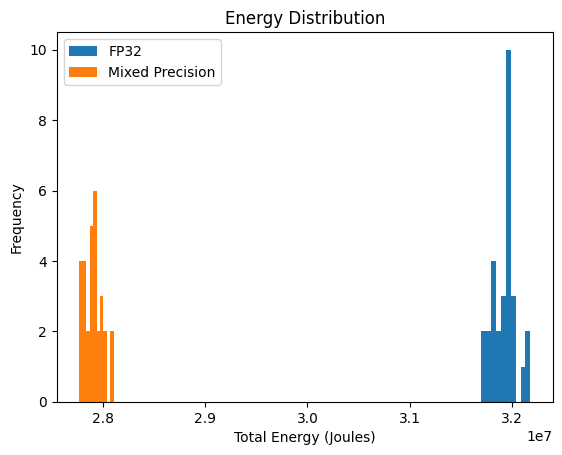

In [38]:
plt.figure()

plt.hist(filtered_energy_totals[filtered_energy_totals["mode"] == "fp32"]["total_energy_joules"], bins=10, label="FP32")
plt.hist(filtered_energy_totals[filtered_energy_totals["mode"] == "mixed"]["total_energy_joules"], bins=10, label="Mixed Precision")

plt.xlabel("Total Energy (Joules)")
plt.ylabel("Frequency")
plt.title("Energy Distribution")
plt.legend()
plt.show()


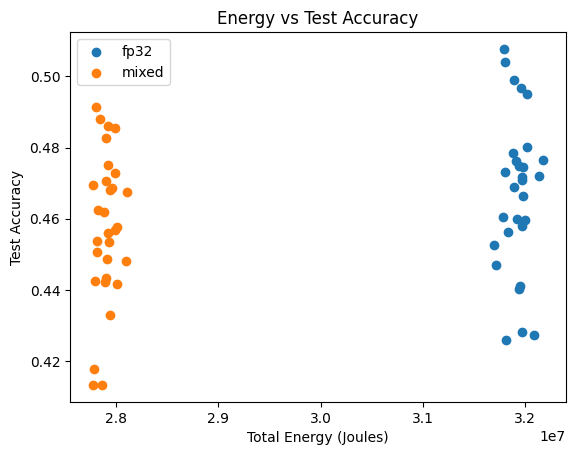

In [39]:
results_df["run_id"] = results_df["run_id"].astype(int)

merged_filtered = pd.merge(
    filtered_energy_totals,
    results_df,
    on=["run_id", "mode"]
)

plt.figure()

for mode in merged_filtered["mode"].unique():
    subset = merged_filtered[merged_filtered["mode"] == mode]
    plt.scatter(subset["total_energy_joules"], subset["test_accuracy"], label=mode)

plt.xlabel("Total Energy (Joules)")
plt.ylabel("Test Accuracy")
plt.title("Energy vs Test Accuracy")
plt.legend()
plt.show()


In [40]:
from scipy.stats import shapiro

# Shapiro-Wilk test
stat_fp32, p_fp32 = shapiro(filtered_energy_totals[filtered_energy_totals["mode"] == "fp32"]["total_energy_joules"])
stat_mixed, p_mixed = shapiro(filtered_energy_totals[filtered_energy_totals["mode"] == "mixed"]["total_energy_joules"])

print("FP32:")
print("  Statistic =", stat_fp32)
print("  p-value   =", p_fp32)

print("\nMixed Precision:")
print("  Statistic =", stat_mixed)
print("  p-value   =", p_mixed)


FP32:
  Statistic = 0.9709836989321655
  p-value   = 0.5866680387613271

Mixed Precision:
  Statistic = 0.9576269420259854
  p-value   = 0.2690601988418469
